# Credit Risk Resampling Techniques

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [32]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [33]:
# Load the data
file_path = Path('./Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [34]:
# Retrieve the column name and number of categories of object data
df.select_dtypes(include=['object']).nunique()

home_ownership          4
verification_status     3
issue_d                 3
loan_status             2
pymnt_plan              1
initial_list_status     2
next_pymnt_d            2
application_type        2
hardship_flag           1
debt_settlement_flag    1
dtype: int64

In [35]:
# Encode string variables for features
features_df = df.drop("loan_status", axis= 1)
encoded_df = pd.get_dummies(features_df, columns=features_df.columns[(features_df.dtypes == "object")])
encoded_df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [36]:
# Create our features
X = encoded_df

# Create our target
y = df["loan_status"]

In [37]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [38]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [40]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51369, 'high_risk': 51369})

In [41]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="lbfgs", random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [42]:
# Calculated the balanced accuracy score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.6363066937156172


In [43]:
# Display the confusion matrix
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
 [[   60    44]
 [ 5204 11897]]


In [44]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(f"Imbalanced Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

Imbalanced Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.58      0.70      0.02      0.63      0.40       104
   low_risk       1.00      0.70      0.58      0.82      0.63      0.41     17101

avg / total       0.99      0.69      0.58      0.81      0.63      0.41     17205



Accuracy Score: 0.6363066937156172
Confusion Matrix


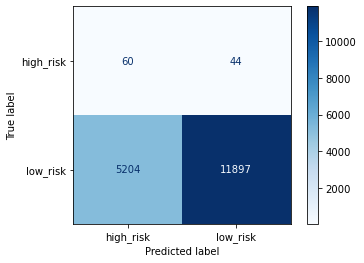

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.58      0.70      0.02      0.63      0.40       104
   low_risk       1.00      0.70      0.58      0.82      0.63      0.41     17101

avg / total       0.99      0.69      0.58      0.81      0.63      0.41     17205



In [45]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

### SMOTE Oversampling

In [46]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=42, sampling_strategy= "auto").fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51369, 'high_risk': 51369})

In [47]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver= "lbfgs", random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [48]:
# Calculated the balanced accuracy score
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.6297399387350268


In [49]:
# Display the confusion matrix
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
 [[   54    50]
 [ 4442 12659]]


In [50]:
# Print the imbalanced classification report
print(f"Imbalanced Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

Imbalanced Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.52      0.74      0.02      0.62      0.38       104
   low_risk       1.00      0.74      0.52      0.85      0.62      0.39     17101

avg / total       0.99      0.74      0.52      0.84      0.62      0.39     17205



Accuracy Score: 0.6297399387350268
Confusion Matrix


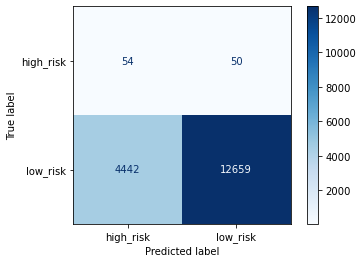

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.52      0.74      0.02      0.62      0.38       104
   low_risk       1.00      0.74      0.52      0.85      0.62      0.39     17101

avg / total       0.99      0.74      0.52      0.84      0.62      0.39     17205



In [51]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [52]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 243, 'low_risk': 243})

In [53]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver= "lbfgs", random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [54]:
# Calculated the balanced accuracy score
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.5548036439614418


In [55]:
# Display the confusion matrix
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
 [[  61   43]
 [8156 8945]]


In [56]:
# Print the imbalanced classification report
print(f"Imbalanced Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

Imbalanced Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.59      0.52      0.01      0.55      0.31       104
   low_risk       1.00      0.52      0.59      0.69      0.55      0.30     17101

avg / total       0.99      0.52      0.59      0.68      0.55      0.30     17205



Accuracy Score: 0.5548036439614418
Confusion Matrix


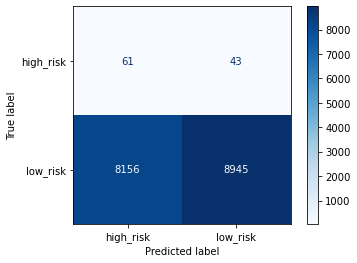

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.59      0.52      0.01      0.55      0.31       104
   low_risk       1.00      0.52      0.59      0.69      0.55      0.30     17101

avg / total       0.99      0.52      0.59      0.68      0.55      0.30     17205



In [57]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [58]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'high_risk': 68455, 'low_risk': 62028})

In [59]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver= "lbfgs", random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [60]:
# Calculated the balanced accuracy score
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.6591227795945356


In [61]:
# Display the confusion matrix
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
 [[  77   27]
 [7219 9882]]


In [62]:
# Print the imbalanced classification report
print(f"Imbalanced Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

Imbalanced Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.74      0.58      0.02      0.65      0.43       104
   low_risk       1.00      0.58      0.74      0.73      0.65      0.42     17101

avg / total       0.99      0.58      0.74      0.73      0.65      0.42     17205



Accuracy Score: 0.6591227795945356
Confusion Matrix


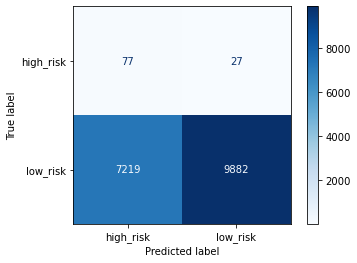

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.74      0.58      0.02      0.65      0.43       104
   low_risk       1.00      0.58      0.74      0.73      0.65      0.42     17101

avg / total       0.99      0.58      0.74      0.73      0.65      0.42     17205



In [63]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")